In [1]:
#Create a folder called celeba in home dir where reconstructed images will be stored
#Considered only 100000 images for training

import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as utils
import gc
import pywt
import IPython
import random
from random import sample

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
no_of_sample = 1
CUDA = True
BATCH_SIZE = 32
LOG_INTERVAL = 5
h_img = 64
w_img = 64
flat = h_img*w_img*3
train_losses = []

In [2]:
w=pywt.Wavelet('bior2.2')


dec_hi = torch.Tensor(w.dec_hi[::-1]).cuda() 
dec_lo = torch.Tensor(w.dec_lo[::-1]).cuda()
rec_hi = torch.Tensor(w.rec_hi).cuda()
rec_lo = torch.Tensor(w.rec_lo).cuda()
dec_hi_cpu = torch.Tensor(w.dec_hi[::-1]).clone().cpu()
dec_lo_cpu = torch.Tensor(w.dec_lo[::-1]).clone().cpu()
rec_hi_cpu = torch.Tensor(w.rec_hi).clone().cpu()
rec_lo_cpu = torch.Tensor(w.rec_lo).clone().cpu()


filters = torch.stack([dec_lo_cpu.unsqueeze(0)*dec_lo_cpu.unsqueeze(1),
                       dec_lo_cpu.unsqueeze(0)*dec_hi_cpu.unsqueeze(1),
                       dec_hi_cpu.unsqueeze(0)*dec_lo_cpu.unsqueeze(1),
                       dec_hi_cpu.unsqueeze(0)*dec_hi_cpu.unsqueeze(1)], dim=0)

inv_filters = torch.stack([rec_lo.unsqueeze(0)*rec_lo.unsqueeze(1),
                           rec_lo.unsqueeze(0)*rec_hi.unsqueeze(1),
                           rec_hi.unsqueeze(0)*rec_lo.unsqueeze(1),
                           rec_hi.unsqueeze(0)*rec_hi.unsqueeze(1)], dim=0)


def wt(vimg, levels=1):
    h = vimg.size(2)
    w = vimg.size(3)
#     print(vimg.size())
    padded = torch.nn.functional.pad(vimg,(2,2,2,2))
    res = torch.nn.functional.conv2d(padded, Variable(filters[:,None]),stride=2)
    if levels>1:
        res[:,:1] = wt(res[:,:1],levels-1)
        res[:,:1,32:,:] = res[:,:1,32:,:]*1.
        res[:,:1,:,32:] = res[:,:1,:,32:]*1.
        res[:,1:] = res[:,1:]*1.
    res = res.view(-1,2,h//2,w//2).transpose(1,2).contiguous().view(-1,1,h,w)
    return res



def iwt(vres, levels=1):
    h = vres.size(2)
    w = vres.size(3)
    res = vres.contiguous().view(-1,h//2,2,w//2).transpose(1,2).contiguous().view(-1,4,h//2,w//2).clone()
    if levels>1:
        res[:,:1] = iwt(res[:,:1], levels=levels-1)
    res = torch.nn.functional.conv_transpose2d(res, Variable(inv_filters[:,None]),stride=2)
    res = res[:,:,2:-2,2:-2] #removing padding
#     print(res.shape)
    return res

In [3]:
class CelebaDataset(Dataset):

    def __init__(self, root_dir, img_list, WT=False):
        self.root_dir = root_dir
        self.img_list = img_list
        self.WT = WT

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root_dir, self.img_list[idx]))
        img = np.array(img)
        img = img / 255
        img = torch.from_numpy(img.transpose(2,0,1)).float()
        
        # Returning both original image and WT image if self.WT
        if self.WT:
#             img_wt = torch.from_numpy(img.transpose(2,0,1)).float()
            img_wt = wt(img_wt.unsqueeze(1)).squeeze()

            return img, img_wt
        
        return img
    
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors. numpy image: H x W x C, torch image: C X H X W
    """

    def __call__(self, image, invert_arrays=True):

        if invert_arrays:
            image = image.transpose((2, 0, 1))[:,:h_img*2,:w_img*2]

        return torch.from_numpy(image)

4

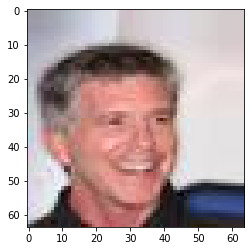

In [4]:
# Creating and testing dataset with WT & IWT
random.seed(2020)
root_dir = "/disk_c/han/celeba64/"
image_files = os.listdir(root_dir)

ds = CelebaDataset('/disk_c/han/celeba64/', image_files, WT=False)
ds_loader = DataLoader(ds, batch_size=1, num_workers=10, shuffle=True)

# Show original img
t = ds[0]
plt.imshow(t.numpy().transpose((1,2,0)))

gc.collect()

In [22]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class UnFlatten(nn.Module):
    def forward(self, input, size=2048):
        return input.view(input.size(0), size, 1, 1)

class UnFlatten1(nn.Module):        
    def forward(self, input, size=512):
        return input.view(input.size(0), 512, 2, 2)


class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=2048, z_dim=100):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2), # N * 32 * 31 * 31
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2), # N * 64 * 14 * 14,
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2), # N * 128 * 6 * 6
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2), # N * 256 * 2 * 2
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=1, stride=1), # N * 512 * 2 * 2
            nn.BatchNorm2d(512),
            nn.ReLU(),
            Flatten()
        )

        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)

#         # Decoder
#         self.fct_decode_1 = nn.Sequential(
#             UnFlatten(),
#             nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2), # N * 128 * 5 * 5
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2), # N * 64 * 13 * 13
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2), # N * 64 * 30 * 30
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2), # N * 3 * 64 * 64
#             nn.Sigmoid(),
#         )
        
        # (H−1)×stride[0]+(kernel_size[0]
        # Decoder
        self.fct_decode_1 = nn.Sequential(
            UnFlatten1(),                                          # N * 512 * 2 * 2
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2), # N * 256 * 6 * 6
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2), # N * 128 * 14 * 14
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2), # N * 64 * 30 * 30
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2), # N * 32 * 62 * 62
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=3, stride=1), # N * 3 * 64 * 64 
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Sigmoid(),
        )
        
        self.wt1 = nn.Sequential(
            nn.Conv2d(image_channels, image_channels, kernel_size=5, stride=1, padding=2), # N * 3 * 64 * 64
            nn.BatchNorm2d(image_channels)
        )
        
        self.wt2 = nn.Sequential(
            nn.Conv2d(image_channels, image_channels, kernel_size=5, stride=1, padding=2), # N * 3 * 64 * 64
            nn.BatchNorm2d(image_channels)
        )
        
#         self.wt3 = nn.Sequential(
#             nn.Conv2d(image_channels, image_channels, kernel_size=5, stride=1, padding=2), # N * 3 * 64 * 64
#             nn.BatchNorm2d(image_channels)
#         )
        

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            # return torch.normal(mu, std)
            esp = torch.randn(*mu.size()).cuda()
            z = mu + std * esp
            return z
        else:
            return mu
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.fct_decode_1(z)
        z = self.wt1(z)
        z = self.wt2(z)
#         z = self.wt3(z)
        
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar
       
#         z_final = Variable(torch.stack([z_1,z_2,z_3,z_4], dim=1))
#         z_final = z_final.view(-1,2,128//2,128//2).transpose(1,2).contiguous().view(-1,1,128,128)

    def loss_function(self, wt_x, x, mu, logvar) -> Variable:
        
        wt_x = wt_x.view(-1,1,64,64)
        x_recon = iwt(wt_x, levels=3)
        x_recon = x_recon.view(-1,3,64,64)
        x_recon = x_recon.contiguous()
        
        # Loss btw reconstructed img and original img
        BCE = F.l1_loss(x_recon.view(-1, 3 * 64 * 64), x.view(-1, 3 * 64 * 64))

        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * 0.0001
        KLD /= BATCH_SIZE * 3 * 64 * 64

        return BCE + KLD

In [6]:

def train(epoch, model, optimizer, train_loader):
    # toggle model to train mode
    model.train()
    train_loss = 0
    
    for batch_idx, data in enumerate(train_loader):
        
        if CUDA:
            data = data.cuda()

        optimizer.zero_grad()
        
        wt_batch, mu, logvar = model(data)
        loss = model.loss_function(wt_batch, data, mu, logvar)
        loss.backward()
        
        train_losses.append(loss.item())
        train_loss += loss
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data),
                                                                           len(train_loader.dataset),
                                                                           100. * batch_idx / len(train_loader),
                                                                           loss / len(data)))
            
            n = min(data.size(0), 8)
           

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))




In [15]:
train_dataset = CelebaDataset(root_dir, image_files, WT=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=10, shuffle=True)

In [18]:
# train_losses = []
# gc.collect()
# EPOCHS = 100
# model = VAE()
# if CUDA: 
#     print('CUDA = {}'.format(CUDA))
#     model.cuda()
# #     x_sample = torch.randn(32,3,64,64).cuda()
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

# for epoch in range(1, EPOCHS + 1):
#     train(epoch, model, optimizer, train_loader)

#     # 64 sets of random ZDIMS-float vectors, i.e. 64 locations / MNIST
#     # digits in latent space
#     sample = Variable(torch.randn(32,100))
#     if CUDA:
#         sample = sample.cuda()
#     x_sample1 = model.decode(sample)
#     save_image(x_sample1[:8].cpu(), '/disk_c/han/image_samples/celeba_wtvae64_2wt_1/decoded_sample' + str(epoch) + '.png')  
    
#     x_sample1 = x_sample1.view(-1,1,64,64)
#     x_sample1 = iwt(x_sample1, levels=3)
#     x_sample1 = x_sample1.view(-1,3,64,64)
# #     x_sample1 /= torch.max(x_sample1)
    
#     x_sample1 = x_sample1.contiguous()
#     save_image(x_sample1[:8].cpu(), '/disk_c/han/image_samples/celeba_wtvae64_2wt_1/sample' + str(epoch) + '.png')  
    
#     torch.save(model.state_dict(), '/disk_c/han/models/wtvae64_2wt_models_1/wtvae_epoch{}.pth'.format(epoch))
    

    

CUDA = True
Train Epoch: 1 [0/10000 (0%)]	Loss: 0.029518
Train Epoch: 1 [160/10000 (2%)]	Loss: 0.018176
Train Epoch: 1 [320/10000 (3%)]	Loss: 0.014234
Train Epoch: 1 [480/10000 (5%)]	Loss: 0.012150
Train Epoch: 1 [640/10000 (6%)]	Loss: 0.011116
Train Epoch: 1 [800/10000 (8%)]	Loss: 0.010298
Train Epoch: 1 [960/10000 (10%)]	Loss: 0.010533
Train Epoch: 1 [1120/10000 (11%)]	Loss: 0.010145
Train Epoch: 1 [1280/10000 (13%)]	Loss: 0.009510
Train Epoch: 1 [1440/10000 (14%)]	Loss: 0.008980
Train Epoch: 1 [1600/10000 (16%)]	Loss: 0.008791
Train Epoch: 1 [1760/10000 (18%)]	Loss: 0.009274
Train Epoch: 1 [1920/10000 (19%)]	Loss: 0.008449
Train Epoch: 1 [2080/10000 (21%)]	Loss: 0.008877
Train Epoch: 1 [2240/10000 (22%)]	Loss: 0.008380
Train Epoch: 1 [2400/10000 (24%)]	Loss: 0.008851
Train Epoch: 1 [2560/10000 (26%)]	Loss: 0.008351
Train Epoch: 1 [2720/10000 (27%)]	Loss: 0.008592
Train Epoch: 1 [2880/10000 (29%)]	Loss: 0.008304
Train Epoch: 1 [3040/10000 (30%)]	Loss: 0.007731
Train Epoch: 1 [3200/10

Train Epoch: 3 [6720/10000 (67%)]	Loss: 0.005351
Train Epoch: 3 [6880/10000 (69%)]	Loss: 0.004955
Train Epoch: 3 [7040/10000 (70%)]	Loss: 0.005037
Train Epoch: 3 [7200/10000 (72%)]	Loss: 0.005416
Train Epoch: 3 [7360/10000 (73%)]	Loss: 0.005509
Train Epoch: 3 [7520/10000 (75%)]	Loss: 0.005143
Train Epoch: 3 [7680/10000 (77%)]	Loss: 0.005366
Train Epoch: 3 [7840/10000 (78%)]	Loss: 0.005112
Train Epoch: 3 [8000/10000 (80%)]	Loss: 0.004725
Train Epoch: 3 [8160/10000 (81%)]	Loss: 0.005127
Train Epoch: 3 [8320/10000 (83%)]	Loss: 0.004914
Train Epoch: 3 [8480/10000 (85%)]	Loss: 0.004754
Train Epoch: 3 [8640/10000 (86%)]	Loss: 0.005060
Train Epoch: 3 [8800/10000 (88%)]	Loss: 0.004786
Train Epoch: 3 [8960/10000 (89%)]	Loss: 0.004899
Train Epoch: 3 [9120/10000 (91%)]	Loss: 0.004851
Train Epoch: 3 [9280/10000 (93%)]	Loss: 0.004991
Train Epoch: 3 [9440/10000 (94%)]	Loss: 0.005086
Train Epoch: 3 [9600/10000 (96%)]	Loss: 0.005012
Train Epoch: 3 [9760/10000 (97%)]	Loss: 0.004778
Train Epoch: 3 [9920

Train Epoch: 6 [3200/10000 (32%)]	Loss: 0.004380
Train Epoch: 6 [3360/10000 (34%)]	Loss: 0.004306
Train Epoch: 6 [3520/10000 (35%)]	Loss: 0.004617
Train Epoch: 6 [3680/10000 (37%)]	Loss: 0.004209
Train Epoch: 6 [3840/10000 (38%)]	Loss: 0.004239
Train Epoch: 6 [4000/10000 (40%)]	Loss: 0.004475
Train Epoch: 6 [4160/10000 (42%)]	Loss: 0.004381
Train Epoch: 6 [4320/10000 (43%)]	Loss: 0.004052
Train Epoch: 6 [4480/10000 (45%)]	Loss: 0.004256
Train Epoch: 6 [4640/10000 (46%)]	Loss: 0.004359
Train Epoch: 6 [4800/10000 (48%)]	Loss: 0.004322
Train Epoch: 6 [4960/10000 (50%)]	Loss: 0.004761
Train Epoch: 6 [5120/10000 (51%)]	Loss: 0.004344
Train Epoch: 6 [5280/10000 (53%)]	Loss: 0.004524
Train Epoch: 6 [5440/10000 (54%)]	Loss: 0.004263
Train Epoch: 6 [5600/10000 (56%)]	Loss: 0.004237
Train Epoch: 6 [5760/10000 (58%)]	Loss: 0.004202
Train Epoch: 6 [5920/10000 (59%)]	Loss: 0.004394
Train Epoch: 6 [6080/10000 (61%)]	Loss: 0.004305
Train Epoch: 6 [6240/10000 (62%)]	Loss: 0.004222
Train Epoch: 6 [6400

Train Epoch: 8 [9920/10000 (99%)]	Loss: 0.004305
====> Epoch: 8 Average loss: 0.0042
Train Epoch: 9 [0/10000 (0%)]	Loss: 0.004061
Train Epoch: 9 [160/10000 (2%)]	Loss: 0.004370
Train Epoch: 9 [320/10000 (3%)]	Loss: 0.004083
Train Epoch: 9 [480/10000 (5%)]	Loss: 0.003786
Train Epoch: 9 [640/10000 (6%)]	Loss: 0.003786
Train Epoch: 9 [800/10000 (8%)]	Loss: 0.004188
Train Epoch: 9 [960/10000 (10%)]	Loss: 0.004253
Train Epoch: 9 [1120/10000 (11%)]	Loss: 0.004127
Train Epoch: 9 [1280/10000 (13%)]	Loss: 0.004141
Train Epoch: 9 [1440/10000 (14%)]	Loss: 0.004127
Train Epoch: 9 [1600/10000 (16%)]	Loss: 0.003826
Train Epoch: 9 [1760/10000 (18%)]	Loss: 0.003928
Train Epoch: 9 [1920/10000 (19%)]	Loss: 0.003917
Train Epoch: 9 [2080/10000 (21%)]	Loss: 0.004105
Train Epoch: 9 [2240/10000 (22%)]	Loss: 0.003904
Train Epoch: 9 [2400/10000 (24%)]	Loss: 0.004067
Train Epoch: 9 [2560/10000 (26%)]	Loss: 0.003975
Train Epoch: 9 [2720/10000 (27%)]	Loss: 0.004176
Train Epoch: 9 [2880/10000 (29%)]	Loss: 0.004094

Train Epoch: 11 [6080/10000 (61%)]	Loss: 0.004238
Train Epoch: 11 [6240/10000 (62%)]	Loss: 0.003770
Train Epoch: 11 [6400/10000 (64%)]	Loss: 0.003730
Train Epoch: 11 [6560/10000 (65%)]	Loss: 0.004020
Train Epoch: 11 [6720/10000 (67%)]	Loss: 0.004010
Train Epoch: 11 [6880/10000 (69%)]	Loss: 0.003528
Train Epoch: 11 [7040/10000 (70%)]	Loss: 0.004215
Train Epoch: 11 [7200/10000 (72%)]	Loss: 0.003960
Train Epoch: 11 [7360/10000 (73%)]	Loss: 0.004026
Train Epoch: 11 [7520/10000 (75%)]	Loss: 0.004047
Train Epoch: 11 [7680/10000 (77%)]	Loss: 0.004115
Train Epoch: 11 [7840/10000 (78%)]	Loss: 0.003804
Train Epoch: 11 [8000/10000 (80%)]	Loss: 0.004254
Train Epoch: 11 [8160/10000 (81%)]	Loss: 0.003639
Train Epoch: 11 [8320/10000 (83%)]	Loss: 0.004107
Train Epoch: 11 [8480/10000 (85%)]	Loss: 0.004217
Train Epoch: 11 [8640/10000 (86%)]	Loss: 0.003919
Train Epoch: 11 [8800/10000 (88%)]	Loss: 0.003839
Train Epoch: 11 [8960/10000 (89%)]	Loss: 0.003692
Train Epoch: 11 [9120/10000 (91%)]	Loss: 0.003739


Train Epoch: 14 [1920/10000 (19%)]	Loss: 0.003475
Train Epoch: 14 [2080/10000 (21%)]	Loss: 0.003858
Train Epoch: 14 [2240/10000 (22%)]	Loss: 0.003714
Train Epoch: 14 [2400/10000 (24%)]	Loss: 0.003791
Train Epoch: 14 [2560/10000 (26%)]	Loss: 0.003837
Train Epoch: 14 [2720/10000 (27%)]	Loss: 0.003905
Train Epoch: 14 [2880/10000 (29%)]	Loss: 0.003866
Train Epoch: 14 [3040/10000 (30%)]	Loss: 0.003690
Train Epoch: 14 [3200/10000 (32%)]	Loss: 0.004000
Train Epoch: 14 [3360/10000 (34%)]	Loss: 0.003680
Train Epoch: 14 [3520/10000 (35%)]	Loss: 0.003746
Train Epoch: 14 [3680/10000 (37%)]	Loss: 0.003600
Train Epoch: 14 [3840/10000 (38%)]	Loss: 0.003894
Train Epoch: 14 [4000/10000 (40%)]	Loss: 0.003736
Train Epoch: 14 [4160/10000 (42%)]	Loss: 0.003821
Train Epoch: 14 [4320/10000 (43%)]	Loss: 0.003539
Train Epoch: 14 [4480/10000 (45%)]	Loss: 0.003905
Train Epoch: 14 [4640/10000 (46%)]	Loss: 0.003625
Train Epoch: 14 [4800/10000 (48%)]	Loss: 0.003641
Train Epoch: 14 [4960/10000 (50%)]	Loss: 0.003644


Train Epoch: 16 [8000/10000 (80%)]	Loss: 0.003559
Train Epoch: 16 [8160/10000 (81%)]	Loss: 0.003400
Train Epoch: 16 [8320/10000 (83%)]	Loss: 0.003562
Train Epoch: 16 [8480/10000 (85%)]	Loss: 0.003782
Train Epoch: 16 [8640/10000 (86%)]	Loss: 0.003963
Train Epoch: 16 [8800/10000 (88%)]	Loss: 0.003519
Train Epoch: 16 [8960/10000 (89%)]	Loss: 0.003479
Train Epoch: 16 [9120/10000 (91%)]	Loss: 0.003903
Train Epoch: 16 [9280/10000 (93%)]	Loss: 0.003486
Train Epoch: 16 [9440/10000 (94%)]	Loss: 0.003751
Train Epoch: 16 [9600/10000 (96%)]	Loss: 0.003476
Train Epoch: 16 [9760/10000 (97%)]	Loss: 0.003281
Train Epoch: 16 [9920/10000 (99%)]	Loss: 0.003546
====> Epoch: 16 Average loss: 0.0036
Train Epoch: 17 [0/10000 (0%)]	Loss: 0.003474
Train Epoch: 17 [160/10000 (2%)]	Loss: 0.003500
Train Epoch: 17 [320/10000 (3%)]	Loss: 0.003688
Train Epoch: 17 [480/10000 (5%)]	Loss: 0.003714
Train Epoch: 17 [640/10000 (6%)]	Loss: 0.003413
Train Epoch: 17 [800/10000 (8%)]	Loss: 0.003401
Train Epoch: 17 [960/10000 

Train Epoch: 19 [3840/10000 (38%)]	Loss: 0.003329
Train Epoch: 19 [4000/10000 (40%)]	Loss: 0.003485
Train Epoch: 19 [4160/10000 (42%)]	Loss: 0.003475
Train Epoch: 19 [4320/10000 (43%)]	Loss: 0.003253
Train Epoch: 19 [4480/10000 (45%)]	Loss: 0.003403
Train Epoch: 19 [4640/10000 (46%)]	Loss: 0.003446
Train Epoch: 19 [4800/10000 (48%)]	Loss: 0.003544
Train Epoch: 19 [4960/10000 (50%)]	Loss: 0.003578
Train Epoch: 19 [5120/10000 (51%)]	Loss: 0.003635
Train Epoch: 19 [5280/10000 (53%)]	Loss: 0.003580
Train Epoch: 19 [5440/10000 (54%)]	Loss: 0.003825
Train Epoch: 19 [5600/10000 (56%)]	Loss: 0.003429
Train Epoch: 19 [5760/10000 (58%)]	Loss: 0.003375
Train Epoch: 19 [5920/10000 (59%)]	Loss: 0.003403
Train Epoch: 19 [6080/10000 (61%)]	Loss: 0.003575
Train Epoch: 19 [6240/10000 (62%)]	Loss: 0.003590
Train Epoch: 19 [6400/10000 (64%)]	Loss: 0.003593
Train Epoch: 19 [6560/10000 (65%)]	Loss: 0.003523
Train Epoch: 19 [6720/10000 (67%)]	Loss: 0.003542
Train Epoch: 19 [6880/10000 (69%)]	Loss: 0.003416


Train Epoch: 21 [9920/10000 (99%)]	Loss: 0.003573
====> Epoch: 21 Average loss: 0.0034
Train Epoch: 22 [0/10000 (0%)]	Loss: 0.003269
Train Epoch: 22 [160/10000 (2%)]	Loss: 0.003546
Train Epoch: 22 [320/10000 (3%)]	Loss: 0.003205
Train Epoch: 22 [480/10000 (5%)]	Loss: 0.003362
Train Epoch: 22 [640/10000 (6%)]	Loss: 0.003314
Train Epoch: 22 [800/10000 (8%)]	Loss: 0.003499
Train Epoch: 22 [960/10000 (10%)]	Loss: 0.003604
Train Epoch: 22 [1120/10000 (11%)]	Loss: 0.003349
Train Epoch: 22 [1280/10000 (13%)]	Loss: 0.003467
Train Epoch: 22 [1440/10000 (14%)]	Loss: 0.003354
Train Epoch: 22 [1600/10000 (16%)]	Loss: 0.003321
Train Epoch: 22 [1760/10000 (18%)]	Loss: 0.003288
Train Epoch: 22 [1920/10000 (19%)]	Loss: 0.003464
Train Epoch: 22 [2080/10000 (21%)]	Loss: 0.003261
Train Epoch: 22 [2240/10000 (22%)]	Loss: 0.003440
Train Epoch: 22 [2400/10000 (24%)]	Loss: 0.003221
Train Epoch: 22 [2560/10000 (26%)]	Loss: 0.003468
Train Epoch: 22 [2720/10000 (27%)]	Loss: 0.003115
Train Epoch: 22 [2880/10000 

Train Epoch: 24 [5760/10000 (58%)]	Loss: 0.003203
Train Epoch: 24 [5920/10000 (59%)]	Loss: 0.003231
Train Epoch: 24 [6080/10000 (61%)]	Loss: 0.003126
Train Epoch: 24 [6240/10000 (62%)]	Loss: 0.003238
Train Epoch: 24 [6400/10000 (64%)]	Loss: 0.003271
Train Epoch: 24 [6560/10000 (65%)]	Loss: 0.003169
Train Epoch: 24 [6720/10000 (67%)]	Loss: 0.003099
Train Epoch: 24 [6880/10000 (69%)]	Loss: 0.003833
Train Epoch: 24 [7040/10000 (70%)]	Loss: 0.003397
Train Epoch: 24 [7200/10000 (72%)]	Loss: 0.003307
Train Epoch: 24 [7360/10000 (73%)]	Loss: 0.003295
Train Epoch: 24 [7520/10000 (75%)]	Loss: 0.003461
Train Epoch: 24 [7680/10000 (77%)]	Loss: 0.003306
Train Epoch: 24 [7840/10000 (78%)]	Loss: 0.003334
Train Epoch: 24 [8000/10000 (80%)]	Loss: 0.003451
Train Epoch: 24 [8160/10000 (81%)]	Loss: 0.003134
Train Epoch: 24 [8320/10000 (83%)]	Loss: 0.003361
Train Epoch: 24 [8480/10000 (85%)]	Loss: 0.003224
Train Epoch: 24 [8640/10000 (86%)]	Loss: 0.003132
Train Epoch: 24 [8800/10000 (88%)]	Loss: 0.003343


Train Epoch: 27 [1600/10000 (16%)]	Loss: 0.003242
Train Epoch: 27 [1760/10000 (18%)]	Loss: 0.003029
Train Epoch: 27 [1920/10000 (19%)]	Loss: 0.003332
Train Epoch: 27 [2080/10000 (21%)]	Loss: 0.003231
Train Epoch: 27 [2240/10000 (22%)]	Loss: 0.003218
Train Epoch: 27 [2400/10000 (24%)]	Loss: 0.003212
Train Epoch: 27 [2560/10000 (26%)]	Loss: 0.003254
Train Epoch: 27 [2720/10000 (27%)]	Loss: 0.003290
Train Epoch: 27 [2880/10000 (29%)]	Loss: 0.003279
Train Epoch: 27 [3040/10000 (30%)]	Loss: 0.003253
Train Epoch: 27 [3200/10000 (32%)]	Loss: 0.003438
Train Epoch: 27 [3360/10000 (34%)]	Loss: 0.003117
Train Epoch: 27 [3520/10000 (35%)]	Loss: 0.003270
Train Epoch: 27 [3680/10000 (37%)]	Loss: 0.003097
Train Epoch: 27 [3840/10000 (38%)]	Loss: 0.003038
Train Epoch: 27 [4000/10000 (40%)]	Loss: 0.003297
Train Epoch: 27 [4160/10000 (42%)]	Loss: 0.003311
Train Epoch: 27 [4320/10000 (43%)]	Loss: 0.003153
Train Epoch: 27 [4480/10000 (45%)]	Loss: 0.003263
Train Epoch: 27 [4640/10000 (46%)]	Loss: 0.003422


Train Epoch: 29 [7680/10000 (77%)]	Loss: 0.003236
Train Epoch: 29 [7840/10000 (78%)]	Loss: 0.003175
Train Epoch: 29 [8000/10000 (80%)]	Loss: 0.003144
Train Epoch: 29 [8160/10000 (81%)]	Loss: 0.003272
Train Epoch: 29 [8320/10000 (83%)]	Loss: 0.003251
Train Epoch: 29 [8480/10000 (85%)]	Loss: 0.003480
Train Epoch: 29 [8640/10000 (86%)]	Loss: 0.002913
Train Epoch: 29 [8800/10000 (88%)]	Loss: 0.003024
Train Epoch: 29 [8960/10000 (89%)]	Loss: 0.003175
Train Epoch: 29 [9120/10000 (91%)]	Loss: 0.003071
Train Epoch: 29 [9280/10000 (93%)]	Loss: 0.003534
Train Epoch: 29 [9440/10000 (94%)]	Loss: 0.003192
Train Epoch: 29 [9600/10000 (96%)]	Loss: 0.003378
Train Epoch: 29 [9760/10000 (97%)]	Loss: 0.003124
Train Epoch: 29 [9920/10000 (99%)]	Loss: 0.003313
====> Epoch: 29 Average loss: 0.0032
Train Epoch: 30 [0/10000 (0%)]	Loss: 0.003129
Train Epoch: 30 [160/10000 (2%)]	Loss: 0.003020
Train Epoch: 30 [320/10000 (3%)]	Loss: 0.003183
Train Epoch: 30 [480/10000 (5%)]	Loss: 0.003143
Train Epoch: 30 [640/10

Train Epoch: 32 [3520/10000 (35%)]	Loss: 0.003253
Train Epoch: 32 [3680/10000 (37%)]	Loss: 0.003296
Train Epoch: 32 [3840/10000 (38%)]	Loss: 0.002876
Train Epoch: 32 [4000/10000 (40%)]	Loss: 0.003182
Train Epoch: 32 [4160/10000 (42%)]	Loss: 0.003168
Train Epoch: 32 [4320/10000 (43%)]	Loss: 0.003149
Train Epoch: 32 [4480/10000 (45%)]	Loss: 0.002867
Train Epoch: 32 [4640/10000 (46%)]	Loss: 0.003161
Train Epoch: 32 [4800/10000 (48%)]	Loss: 0.003225
Train Epoch: 32 [4960/10000 (50%)]	Loss: 0.003216
Train Epoch: 32 [5120/10000 (51%)]	Loss: 0.003196
Train Epoch: 32 [5280/10000 (53%)]	Loss: 0.002902
Train Epoch: 32 [5440/10000 (54%)]	Loss: 0.002999
Train Epoch: 32 [5600/10000 (56%)]	Loss: 0.003074
Train Epoch: 32 [5760/10000 (58%)]	Loss: 0.003126
Train Epoch: 32 [5920/10000 (59%)]	Loss: 0.003230
Train Epoch: 32 [6080/10000 (61%)]	Loss: 0.003257
Train Epoch: 32 [6240/10000 (62%)]	Loss: 0.003316
Train Epoch: 32 [6400/10000 (64%)]	Loss: 0.003350
Train Epoch: 32 [6560/10000 (65%)]	Loss: 0.003384


Train Epoch: 34 [9600/10000 (96%)]	Loss: 0.003054
Train Epoch: 34 [9760/10000 (97%)]	Loss: 0.003402
Train Epoch: 34 [9920/10000 (99%)]	Loss: 0.002908
====> Epoch: 34 Average loss: 0.0031
Train Epoch: 35 [0/10000 (0%)]	Loss: 0.002994
Train Epoch: 35 [160/10000 (2%)]	Loss: 0.003294
Train Epoch: 35 [320/10000 (3%)]	Loss: 0.003117
Train Epoch: 35 [480/10000 (5%)]	Loss: 0.003129
Train Epoch: 35 [640/10000 (6%)]	Loss: 0.002886
Train Epoch: 35 [800/10000 (8%)]	Loss: 0.002984
Train Epoch: 35 [960/10000 (10%)]	Loss: 0.002949
Train Epoch: 35 [1120/10000 (11%)]	Loss: 0.003327
Train Epoch: 35 [1280/10000 (13%)]	Loss: 0.003244
Train Epoch: 35 [1440/10000 (14%)]	Loss: 0.002990
Train Epoch: 35 [1600/10000 (16%)]	Loss: 0.003179
Train Epoch: 35 [1760/10000 (18%)]	Loss: 0.003215
Train Epoch: 35 [1920/10000 (19%)]	Loss: 0.003118
Train Epoch: 35 [2080/10000 (21%)]	Loss: 0.003078
Train Epoch: 35 [2240/10000 (22%)]	Loss: 0.003024
Train Epoch: 35 [2400/10000 (24%)]	Loss: 0.003555
Train Epoch: 35 [2560/10000 

Train Epoch: 37 [5440/10000 (54%)]	Loss: 0.003307
Train Epoch: 37 [5600/10000 (56%)]	Loss: 0.003288
Train Epoch: 37 [5760/10000 (58%)]	Loss: 0.003073
Train Epoch: 37 [5920/10000 (59%)]	Loss: 0.002946
Train Epoch: 37 [6080/10000 (61%)]	Loss: 0.002939
Train Epoch: 37 [6240/10000 (62%)]	Loss: 0.002972
Train Epoch: 37 [6400/10000 (64%)]	Loss: 0.003350
Train Epoch: 37 [6560/10000 (65%)]	Loss: 0.003130
Train Epoch: 37 [6720/10000 (67%)]	Loss: 0.003133
Train Epoch: 37 [6880/10000 (69%)]	Loss: 0.003282
Train Epoch: 37 [7040/10000 (70%)]	Loss: 0.002915
Train Epoch: 37 [7200/10000 (72%)]	Loss: 0.003230
Train Epoch: 37 [7360/10000 (73%)]	Loss: 0.003266
Train Epoch: 37 [7520/10000 (75%)]	Loss: 0.003038
Train Epoch: 37 [7680/10000 (77%)]	Loss: 0.003044
Train Epoch: 37 [7840/10000 (78%)]	Loss: 0.002965
Train Epoch: 37 [8000/10000 (80%)]	Loss: 0.003044
Train Epoch: 37 [8160/10000 (81%)]	Loss: 0.003141
Train Epoch: 37 [8320/10000 (83%)]	Loss: 0.003161
Train Epoch: 37 [8480/10000 (85%)]	Loss: 0.002984


Train Epoch: 40 [1280/10000 (13%)]	Loss: 0.003211
Train Epoch: 40 [1440/10000 (14%)]	Loss: 0.002887
Train Epoch: 40 [1600/10000 (16%)]	Loss: 0.002981
Train Epoch: 40 [1760/10000 (18%)]	Loss: 0.003064
Train Epoch: 40 [1920/10000 (19%)]	Loss: 0.002887
Train Epoch: 40 [2080/10000 (21%)]	Loss: 0.003087
Train Epoch: 40 [2240/10000 (22%)]	Loss: 0.003073
Train Epoch: 40 [2400/10000 (24%)]	Loss: 0.003121
Train Epoch: 40 [2560/10000 (26%)]	Loss: 0.002966
Train Epoch: 40 [2720/10000 (27%)]	Loss: 0.003182
Train Epoch: 40 [2880/10000 (29%)]	Loss: 0.002919
Train Epoch: 40 [3040/10000 (30%)]	Loss: 0.002914
Train Epoch: 40 [3200/10000 (32%)]	Loss: 0.003164
Train Epoch: 40 [3360/10000 (34%)]	Loss: 0.003090
Train Epoch: 40 [3520/10000 (35%)]	Loss: 0.003049
Train Epoch: 40 [3680/10000 (37%)]	Loss: 0.002825
Train Epoch: 40 [3840/10000 (38%)]	Loss: 0.003153
Train Epoch: 40 [4000/10000 (40%)]	Loss: 0.003201
Train Epoch: 40 [4160/10000 (42%)]	Loss: 0.003089
Train Epoch: 40 [4320/10000 (43%)]	Loss: 0.003059


Train Epoch: 42 [7360/10000 (73%)]	Loss: 0.002888
Train Epoch: 42 [7520/10000 (75%)]	Loss: 0.002785
Train Epoch: 42 [7680/10000 (77%)]	Loss: 0.002870
Train Epoch: 42 [7840/10000 (78%)]	Loss: 0.002964
Train Epoch: 42 [8000/10000 (80%)]	Loss: 0.003114
Train Epoch: 42 [8160/10000 (81%)]	Loss: 0.002909
Train Epoch: 42 [8320/10000 (83%)]	Loss: 0.003164
Train Epoch: 42 [8480/10000 (85%)]	Loss: 0.002802
Train Epoch: 42 [8640/10000 (86%)]	Loss: 0.002978
Train Epoch: 42 [8800/10000 (88%)]	Loss: 0.002974
Train Epoch: 42 [8960/10000 (89%)]	Loss: 0.003101
Train Epoch: 42 [9120/10000 (91%)]	Loss: 0.003163
Train Epoch: 42 [9280/10000 (93%)]	Loss: 0.002823
Train Epoch: 42 [9440/10000 (94%)]	Loss: 0.003038
Train Epoch: 42 [9600/10000 (96%)]	Loss: 0.002910
Train Epoch: 42 [9760/10000 (97%)]	Loss: 0.003152
Train Epoch: 42 [9920/10000 (99%)]	Loss: 0.002999
====> Epoch: 42 Average loss: 0.0030
Train Epoch: 43 [0/10000 (0%)]	Loss: 0.002865
Train Epoch: 43 [160/10000 (2%)]	Loss: 0.002919
Train Epoch: 43 [32

Train Epoch: 45 [3200/10000 (32%)]	Loss: 0.002775
Train Epoch: 45 [3360/10000 (34%)]	Loss: 0.003156
Train Epoch: 45 [3520/10000 (35%)]	Loss: 0.002894
Train Epoch: 45 [3680/10000 (37%)]	Loss: 0.002938
Train Epoch: 45 [3840/10000 (38%)]	Loss: 0.002814
Train Epoch: 45 [4000/10000 (40%)]	Loss: 0.002853
Train Epoch: 45 [4160/10000 (42%)]	Loss: 0.003012
Train Epoch: 45 [4320/10000 (43%)]	Loss: 0.002787
Train Epoch: 45 [4480/10000 (45%)]	Loss: 0.002882
Train Epoch: 45 [4640/10000 (46%)]	Loss: 0.002922
Train Epoch: 45 [4800/10000 (48%)]	Loss: 0.003230
Train Epoch: 45 [4960/10000 (50%)]	Loss: 0.002753
Train Epoch: 45 [5120/10000 (51%)]	Loss: 0.002835
Train Epoch: 45 [5280/10000 (53%)]	Loss: 0.002857
Train Epoch: 45 [5440/10000 (54%)]	Loss: 0.003301
Train Epoch: 45 [5600/10000 (56%)]	Loss: 0.003148
Train Epoch: 45 [5760/10000 (58%)]	Loss: 0.002724
Train Epoch: 45 [5920/10000 (59%)]	Loss: 0.002942
Train Epoch: 45 [6080/10000 (61%)]	Loss: 0.002683
Train Epoch: 45 [6240/10000 (62%)]	Loss: 0.002686


Train Epoch: 47 [9280/10000 (93%)]	Loss: 0.002888
Train Epoch: 47 [9440/10000 (94%)]	Loss: 0.002929
Train Epoch: 47 [9600/10000 (96%)]	Loss: 0.002740
Train Epoch: 47 [9760/10000 (97%)]	Loss: 0.003075
Train Epoch: 47 [9920/10000 (99%)]	Loss: 0.002896
====> Epoch: 47 Average loss: 0.0029
Train Epoch: 48 [0/10000 (0%)]	Loss: 0.002852
Train Epoch: 48 [160/10000 (2%)]	Loss: 0.003073
Train Epoch: 48 [320/10000 (3%)]	Loss: 0.002725
Train Epoch: 48 [480/10000 (5%)]	Loss: 0.002705
Train Epoch: 48 [640/10000 (6%)]	Loss: 0.002929
Train Epoch: 48 [800/10000 (8%)]	Loss: 0.002850
Train Epoch: 48 [960/10000 (10%)]	Loss: 0.002817
Train Epoch: 48 [1120/10000 (11%)]	Loss: 0.003040
Train Epoch: 48 [1280/10000 (13%)]	Loss: 0.002839
Train Epoch: 48 [1440/10000 (14%)]	Loss: 0.002815
Train Epoch: 48 [1600/10000 (16%)]	Loss: 0.003062
Train Epoch: 48 [1760/10000 (18%)]	Loss: 0.002755
Train Epoch: 48 [1920/10000 (19%)]	Loss: 0.002752
Train Epoch: 48 [2080/10000 (21%)]	Loss: 0.003139
Train Epoch: 48 [2240/10000 

Train Epoch: 50 [5120/10000 (51%)]	Loss: 0.002988
Train Epoch: 50 [5280/10000 (53%)]	Loss: 0.002894
Train Epoch: 50 [5440/10000 (54%)]	Loss: 0.002775
Train Epoch: 50 [5600/10000 (56%)]	Loss: 0.002839
Train Epoch: 50 [5760/10000 (58%)]	Loss: 0.002939
Train Epoch: 50 [5920/10000 (59%)]	Loss: 0.002812
Train Epoch: 50 [6080/10000 (61%)]	Loss: 0.002822
Train Epoch: 50 [6240/10000 (62%)]	Loss: 0.002681
Train Epoch: 50 [6400/10000 (64%)]	Loss: 0.002809
Train Epoch: 50 [6560/10000 (65%)]	Loss: 0.003278
Train Epoch: 50 [6720/10000 (67%)]	Loss: 0.003086
Train Epoch: 50 [6880/10000 (69%)]	Loss: 0.002851
Train Epoch: 50 [7040/10000 (70%)]	Loss: 0.002965
Train Epoch: 50 [7200/10000 (72%)]	Loss: 0.003015
Train Epoch: 50 [7360/10000 (73%)]	Loss: 0.002768
Train Epoch: 50 [7520/10000 (75%)]	Loss: 0.002905
Train Epoch: 50 [7680/10000 (77%)]	Loss: 0.002721
Train Epoch: 50 [7840/10000 (78%)]	Loss: 0.003159
Train Epoch: 50 [8000/10000 (80%)]	Loss: 0.002799
Train Epoch: 50 [8160/10000 (81%)]	Loss: 0.002854


Train Epoch: 53 [960/10000 (10%)]	Loss: 0.002769
Train Epoch: 53 [1120/10000 (11%)]	Loss: 0.003041
Train Epoch: 53 [1280/10000 (13%)]	Loss: 0.002835
Train Epoch: 53 [1440/10000 (14%)]	Loss: 0.003200
Train Epoch: 53 [1600/10000 (16%)]	Loss: 0.002855
Train Epoch: 53 [1760/10000 (18%)]	Loss: 0.002853
Train Epoch: 53 [1920/10000 (19%)]	Loss: 0.002852
Train Epoch: 53 [2080/10000 (21%)]	Loss: 0.002787
Train Epoch: 53 [2240/10000 (22%)]	Loss: 0.002890
Train Epoch: 53 [2400/10000 (24%)]	Loss: 0.002792
Train Epoch: 53 [2560/10000 (26%)]	Loss: 0.002906
Train Epoch: 53 [2720/10000 (27%)]	Loss: 0.002763
Train Epoch: 53 [2880/10000 (29%)]	Loss: 0.002750
Train Epoch: 53 [3040/10000 (30%)]	Loss: 0.002872
Train Epoch: 53 [3200/10000 (32%)]	Loss: 0.002727
Train Epoch: 53 [3360/10000 (34%)]	Loss: 0.002883
Train Epoch: 53 [3520/10000 (35%)]	Loss: 0.002823
Train Epoch: 53 [3680/10000 (37%)]	Loss: 0.002950
Train Epoch: 53 [3840/10000 (38%)]	Loss: 0.002828
Train Epoch: 53 [4000/10000 (40%)]	Loss: 0.002813
T

Train Epoch: 55 [7040/10000 (70%)]	Loss: 0.002714
Train Epoch: 55 [7200/10000 (72%)]	Loss: 0.002702
Train Epoch: 55 [7360/10000 (73%)]	Loss: 0.002733
Train Epoch: 55 [7520/10000 (75%)]	Loss: 0.002795
Train Epoch: 55 [7680/10000 (77%)]	Loss: 0.002722
Train Epoch: 55 [7840/10000 (78%)]	Loss: 0.002944
Train Epoch: 55 [8000/10000 (80%)]	Loss: 0.002590
Train Epoch: 55 [8160/10000 (81%)]	Loss: 0.002755
Train Epoch: 55 [8320/10000 (83%)]	Loss: 0.002692
Train Epoch: 55 [8480/10000 (85%)]	Loss: 0.002892
Train Epoch: 55 [8640/10000 (86%)]	Loss: 0.003172
Train Epoch: 55 [8800/10000 (88%)]	Loss: 0.002897
Train Epoch: 55 [8960/10000 (89%)]	Loss: 0.002907
Train Epoch: 55 [9120/10000 (91%)]	Loss: 0.002784
Train Epoch: 55 [9280/10000 (93%)]	Loss: 0.003015
Train Epoch: 55 [9440/10000 (94%)]	Loss: 0.003031
Train Epoch: 55 [9600/10000 (96%)]	Loss: 0.002883
Train Epoch: 55 [9760/10000 (97%)]	Loss: 0.002787
Train Epoch: 55 [9920/10000 (99%)]	Loss: 0.002940
====> Epoch: 55 Average loss: 0.0029
Train Epoch: 

Train Epoch: 58 [2880/10000 (29%)]	Loss: 0.003488
Train Epoch: 58 [3040/10000 (30%)]	Loss: 0.003116
Train Epoch: 58 [3200/10000 (32%)]	Loss: 0.002849
Train Epoch: 58 [3360/10000 (34%)]	Loss: 0.002842
Train Epoch: 58 [3520/10000 (35%)]	Loss: 0.002774
Train Epoch: 58 [3680/10000 (37%)]	Loss: 0.002769
Train Epoch: 58 [3840/10000 (38%)]	Loss: 0.002632
Train Epoch: 58 [4000/10000 (40%)]	Loss: 0.002896
Train Epoch: 58 [4160/10000 (42%)]	Loss: 0.002706
Train Epoch: 58 [4320/10000 (43%)]	Loss: 0.002641
Train Epoch: 58 [4480/10000 (45%)]	Loss: 0.002803
Train Epoch: 58 [4640/10000 (46%)]	Loss: 0.002753
Train Epoch: 58 [4800/10000 (48%)]	Loss: 0.002838
Train Epoch: 58 [4960/10000 (50%)]	Loss: 0.002919
Train Epoch: 58 [5120/10000 (51%)]	Loss: 0.002674
Train Epoch: 58 [5280/10000 (53%)]	Loss: 0.002746
Train Epoch: 58 [5440/10000 (54%)]	Loss: 0.002801
Train Epoch: 58 [5600/10000 (56%)]	Loss: 0.002928
Train Epoch: 58 [5760/10000 (58%)]	Loss: 0.002889
Train Epoch: 58 [5920/10000 (59%)]	Loss: 0.002878


Train Epoch: 60 [8960/10000 (89%)]	Loss: 0.002841
Train Epoch: 60 [9120/10000 (91%)]	Loss: 0.002836
Train Epoch: 60 [9280/10000 (93%)]	Loss: 0.002938
Train Epoch: 60 [9440/10000 (94%)]	Loss: 0.002757
Train Epoch: 60 [9600/10000 (96%)]	Loss: 0.002786
Train Epoch: 60 [9760/10000 (97%)]	Loss: 0.002754
Train Epoch: 60 [9920/10000 (99%)]	Loss: 0.002667
====> Epoch: 60 Average loss: 0.0028
Train Epoch: 61 [0/10000 (0%)]	Loss: 0.002634
Train Epoch: 61 [160/10000 (2%)]	Loss: 0.002605
Train Epoch: 61 [320/10000 (3%)]	Loss: 0.002618
Train Epoch: 61 [480/10000 (5%)]	Loss: 0.002738
Train Epoch: 61 [640/10000 (6%)]	Loss: 0.002943
Train Epoch: 61 [800/10000 (8%)]	Loss: 0.003158
Train Epoch: 61 [960/10000 (10%)]	Loss: 0.002794
Train Epoch: 61 [1120/10000 (11%)]	Loss: 0.002674
Train Epoch: 61 [1280/10000 (13%)]	Loss: 0.003038
Train Epoch: 61 [1440/10000 (14%)]	Loss: 0.002853
Train Epoch: 61 [1600/10000 (16%)]	Loss: 0.002916
Train Epoch: 61 [1760/10000 (18%)]	Loss: 0.002638
Train Epoch: 61 [1920/10000 

Train Epoch: 63 [4800/10000 (48%)]	Loss: 0.002911
Train Epoch: 63 [4960/10000 (50%)]	Loss: 0.002818
Train Epoch: 63 [5120/10000 (51%)]	Loss: 0.002812
Train Epoch: 63 [5280/10000 (53%)]	Loss: 0.002799
Train Epoch: 63 [5440/10000 (54%)]	Loss: 0.002725
Train Epoch: 63 [5600/10000 (56%)]	Loss: 0.002601
Train Epoch: 63 [5760/10000 (58%)]	Loss: 0.002675
Train Epoch: 63 [5920/10000 (59%)]	Loss: 0.002722
Train Epoch: 63 [6080/10000 (61%)]	Loss: 0.002804
Train Epoch: 63 [6240/10000 (62%)]	Loss: 0.002709
Train Epoch: 63 [6400/10000 (64%)]	Loss: 0.002667
Train Epoch: 63 [6560/10000 (65%)]	Loss: 0.002808
Train Epoch: 63 [6720/10000 (67%)]	Loss: 0.002849
Train Epoch: 63 [6880/10000 (69%)]	Loss: 0.002635
Train Epoch: 63 [7040/10000 (70%)]	Loss: 0.002800
Train Epoch: 63 [7200/10000 (72%)]	Loss: 0.002700
Train Epoch: 63 [7360/10000 (73%)]	Loss: 0.002722
Train Epoch: 63 [7520/10000 (75%)]	Loss: 0.002876
Train Epoch: 63 [7680/10000 (77%)]	Loss: 0.002835
Train Epoch: 63 [7840/10000 (78%)]	Loss: 0.002825


Train Epoch: 66 [640/10000 (6%)]	Loss: 0.002709
Train Epoch: 66 [800/10000 (8%)]	Loss: 0.002614
Train Epoch: 66 [960/10000 (10%)]	Loss: 0.002942
Train Epoch: 66 [1120/10000 (11%)]	Loss: 0.002728
Train Epoch: 66 [1280/10000 (13%)]	Loss: 0.002747
Train Epoch: 66 [1440/10000 (14%)]	Loss: 0.002716
Train Epoch: 66 [1600/10000 (16%)]	Loss: 0.002665
Train Epoch: 66 [1760/10000 (18%)]	Loss: 0.002803
Train Epoch: 66 [1920/10000 (19%)]	Loss: 0.002695
Train Epoch: 66 [2080/10000 (21%)]	Loss: 0.002780
Train Epoch: 66 [2240/10000 (22%)]	Loss: 0.002934
Train Epoch: 66 [2400/10000 (24%)]	Loss: 0.002829
Train Epoch: 66 [2560/10000 (26%)]	Loss: 0.002826
Train Epoch: 66 [2720/10000 (27%)]	Loss: 0.002534
Train Epoch: 66 [2880/10000 (29%)]	Loss: 0.003145
Train Epoch: 66 [3040/10000 (30%)]	Loss: 0.002577
Train Epoch: 66 [3200/10000 (32%)]	Loss: 0.002997
Train Epoch: 66 [3360/10000 (34%)]	Loss: 0.002808
Train Epoch: 66 [3520/10000 (35%)]	Loss: 0.002677
Train Epoch: 66 [3680/10000 (37%)]	Loss: 0.002726
Train

Train Epoch: 68 [6720/10000 (67%)]	Loss: 0.002803
Train Epoch: 68 [6880/10000 (69%)]	Loss: 0.002644
Train Epoch: 68 [7040/10000 (70%)]	Loss: 0.002959
Train Epoch: 68 [7200/10000 (72%)]	Loss: 0.002556
Train Epoch: 68 [7360/10000 (73%)]	Loss: 0.002683
Train Epoch: 68 [7520/10000 (75%)]	Loss: 0.002916
Train Epoch: 68 [7680/10000 (77%)]	Loss: 0.002779
Train Epoch: 68 [7840/10000 (78%)]	Loss: 0.002604
Train Epoch: 68 [8000/10000 (80%)]	Loss: 0.002844
Train Epoch: 68 [8160/10000 (81%)]	Loss: 0.002762
Train Epoch: 68 [8320/10000 (83%)]	Loss: 0.002963
Train Epoch: 68 [8480/10000 (85%)]	Loss: 0.002841
Train Epoch: 68 [8640/10000 (86%)]	Loss: 0.002694
Train Epoch: 68 [8800/10000 (88%)]	Loss: 0.002826
Train Epoch: 68 [8960/10000 (89%)]	Loss: 0.002737
Train Epoch: 68 [9120/10000 (91%)]	Loss: 0.002707
Train Epoch: 68 [9280/10000 (93%)]	Loss: 0.002878
Train Epoch: 68 [9440/10000 (94%)]	Loss: 0.002716
Train Epoch: 68 [9600/10000 (96%)]	Loss: 0.002809
Train Epoch: 68 [9760/10000 (97%)]	Loss: 0.002697


Train Epoch: 71 [2560/10000 (26%)]	Loss: 0.002847
Train Epoch: 71 [2720/10000 (27%)]	Loss: 0.002597
Train Epoch: 71 [2880/10000 (29%)]	Loss: 0.002532
Train Epoch: 71 [3040/10000 (30%)]	Loss: 0.003018
Train Epoch: 71 [3200/10000 (32%)]	Loss: 0.002944
Train Epoch: 71 [3360/10000 (34%)]	Loss: 0.002720
Train Epoch: 71 [3520/10000 (35%)]	Loss: 0.002804
Train Epoch: 71 [3680/10000 (37%)]	Loss: 0.002781
Train Epoch: 71 [3840/10000 (38%)]	Loss: 0.002606
Train Epoch: 71 [4000/10000 (40%)]	Loss: 0.002618
Train Epoch: 71 [4160/10000 (42%)]	Loss: 0.002751
Train Epoch: 71 [4320/10000 (43%)]	Loss: 0.002695
Train Epoch: 71 [4480/10000 (45%)]	Loss: 0.002629
Train Epoch: 71 [4640/10000 (46%)]	Loss: 0.002889
Train Epoch: 71 [4800/10000 (48%)]	Loss: 0.002824
Train Epoch: 71 [4960/10000 (50%)]	Loss: 0.003240
Train Epoch: 71 [5120/10000 (51%)]	Loss: 0.002783
Train Epoch: 71 [5280/10000 (53%)]	Loss: 0.002870
Train Epoch: 71 [5440/10000 (54%)]	Loss: 0.002783
Train Epoch: 71 [5600/10000 (56%)]	Loss: 0.002712


Train Epoch: 73 [8640/10000 (86%)]	Loss: 0.002768
Train Epoch: 73 [8800/10000 (88%)]	Loss: 0.002773
Train Epoch: 73 [8960/10000 (89%)]	Loss: 0.002534
Train Epoch: 73 [9120/10000 (91%)]	Loss: 0.002731
Train Epoch: 73 [9280/10000 (93%)]	Loss: 0.002764
Train Epoch: 73 [9440/10000 (94%)]	Loss: 0.002602
Train Epoch: 73 [9600/10000 (96%)]	Loss: 0.002644
Train Epoch: 73 [9760/10000 (97%)]	Loss: 0.002782
Train Epoch: 73 [9920/10000 (99%)]	Loss: 0.002858
====> Epoch: 73 Average loss: 0.0027
Train Epoch: 74 [0/10000 (0%)]	Loss: 0.002950
Train Epoch: 74 [160/10000 (2%)]	Loss: 0.002719
Train Epoch: 74 [320/10000 (3%)]	Loss: 0.002717
Train Epoch: 74 [480/10000 (5%)]	Loss: 0.002806
Train Epoch: 74 [640/10000 (6%)]	Loss: 0.002520
Train Epoch: 74 [800/10000 (8%)]	Loss: 0.002799
Train Epoch: 74 [960/10000 (10%)]	Loss: 0.002700
Train Epoch: 74 [1120/10000 (11%)]	Loss: 0.002920
Train Epoch: 74 [1280/10000 (13%)]	Loss: 0.002583
Train Epoch: 74 [1440/10000 (14%)]	Loss: 0.002717
Train Epoch: 74 [1600/10000 

Train Epoch: 76 [4480/10000 (45%)]	Loss: 0.002690
Train Epoch: 76 [4640/10000 (46%)]	Loss: 0.002724
Train Epoch: 76 [4800/10000 (48%)]	Loss: 0.002569
Train Epoch: 76 [4960/10000 (50%)]	Loss: 0.002786
Train Epoch: 76 [5120/10000 (51%)]	Loss: 0.002728
Train Epoch: 76 [5280/10000 (53%)]	Loss: 0.002785
Train Epoch: 76 [5440/10000 (54%)]	Loss: 0.002645
Train Epoch: 76 [5600/10000 (56%)]	Loss: 0.002680
Train Epoch: 76 [5760/10000 (58%)]	Loss: 0.002784
Train Epoch: 76 [5920/10000 (59%)]	Loss: 0.002783
Train Epoch: 76 [6080/10000 (61%)]	Loss: 0.002757
Train Epoch: 76 [6240/10000 (62%)]	Loss: 0.002854
Train Epoch: 76 [6400/10000 (64%)]	Loss: 0.002693
Train Epoch: 76 [6560/10000 (65%)]	Loss: 0.002521
Train Epoch: 76 [6720/10000 (67%)]	Loss: 0.002744
Train Epoch: 76 [6880/10000 (69%)]	Loss: 0.002782
Train Epoch: 76 [7040/10000 (70%)]	Loss: 0.002579
Train Epoch: 76 [7200/10000 (72%)]	Loss: 0.002513
Train Epoch: 76 [7360/10000 (73%)]	Loss: 0.002426
Train Epoch: 76 [7520/10000 (75%)]	Loss: 0.002656


Train Epoch: 79 [320/10000 (3%)]	Loss: 0.002484
Train Epoch: 79 [480/10000 (5%)]	Loss: 0.002793
Train Epoch: 79 [640/10000 (6%)]	Loss: 0.002757
Train Epoch: 79 [800/10000 (8%)]	Loss: 0.002662
Train Epoch: 79 [960/10000 (10%)]	Loss: 0.002553
Train Epoch: 79 [1120/10000 (11%)]	Loss: 0.002859
Train Epoch: 79 [1280/10000 (13%)]	Loss: 0.002435
Train Epoch: 79 [1440/10000 (14%)]	Loss: 0.002678
Train Epoch: 79 [1600/10000 (16%)]	Loss: 0.002496
Train Epoch: 79 [1760/10000 (18%)]	Loss: 0.002692
Train Epoch: 79 [1920/10000 (19%)]	Loss: 0.002476
Train Epoch: 79 [2080/10000 (21%)]	Loss: 0.002686
Train Epoch: 79 [2240/10000 (22%)]	Loss: 0.002612
Train Epoch: 79 [2400/10000 (24%)]	Loss: 0.002626
Train Epoch: 79 [2560/10000 (26%)]	Loss: 0.002836
Train Epoch: 79 [2720/10000 (27%)]	Loss: 0.002873
Train Epoch: 79 [2880/10000 (29%)]	Loss: 0.002543
Train Epoch: 79 [3040/10000 (30%)]	Loss: 0.002691
Train Epoch: 79 [3200/10000 (32%)]	Loss: 0.002878
Train Epoch: 79 [3360/10000 (34%)]	Loss: 0.002605
Train Epo

Train Epoch: 81 [6400/10000 (64%)]	Loss: 0.002550
Train Epoch: 81 [6560/10000 (65%)]	Loss: 0.002903
Train Epoch: 81 [6720/10000 (67%)]	Loss: 0.002722
Train Epoch: 81 [6880/10000 (69%)]	Loss: 0.002611
Train Epoch: 81 [7040/10000 (70%)]	Loss: 0.002655
Train Epoch: 81 [7200/10000 (72%)]	Loss: 0.002632
Train Epoch: 81 [7360/10000 (73%)]	Loss: 0.002642
Train Epoch: 81 [7520/10000 (75%)]	Loss: 0.002713
Train Epoch: 81 [7680/10000 (77%)]	Loss: 0.002628
Train Epoch: 81 [7840/10000 (78%)]	Loss: 0.002744
Train Epoch: 81 [8000/10000 (80%)]	Loss: 0.002797
Train Epoch: 81 [8160/10000 (81%)]	Loss: 0.002876
Train Epoch: 81 [8320/10000 (83%)]	Loss: 0.002725
Train Epoch: 81 [8480/10000 (85%)]	Loss: 0.002678
Train Epoch: 81 [8640/10000 (86%)]	Loss: 0.002560
Train Epoch: 81 [8800/10000 (88%)]	Loss: 0.002628
Train Epoch: 81 [8960/10000 (89%)]	Loss: 0.002814
Train Epoch: 81 [9120/10000 (91%)]	Loss: 0.002766
Train Epoch: 81 [9280/10000 (93%)]	Loss: 0.002689
Train Epoch: 81 [9440/10000 (94%)]	Loss: 0.002417


Train Epoch: 84 [2240/10000 (22%)]	Loss: 0.002537
Train Epoch: 84 [2400/10000 (24%)]	Loss: 0.002520
Train Epoch: 84 [2560/10000 (26%)]	Loss: 0.002481
Train Epoch: 84 [2720/10000 (27%)]	Loss: 0.002720
Train Epoch: 84 [2880/10000 (29%)]	Loss: 0.002781
Train Epoch: 84 [3040/10000 (30%)]	Loss: 0.002711
Train Epoch: 84 [3200/10000 (32%)]	Loss: 0.002764
Train Epoch: 84 [3360/10000 (34%)]	Loss: 0.002861
Train Epoch: 84 [3520/10000 (35%)]	Loss: 0.002519
Train Epoch: 84 [3680/10000 (37%)]	Loss: 0.002568
Train Epoch: 84 [3840/10000 (38%)]	Loss: 0.002831
Train Epoch: 84 [4000/10000 (40%)]	Loss: 0.002519
Train Epoch: 84 [4160/10000 (42%)]	Loss: 0.002731
Train Epoch: 84 [4320/10000 (43%)]	Loss: 0.002742
Train Epoch: 84 [4480/10000 (45%)]	Loss: 0.002772
Train Epoch: 84 [4640/10000 (46%)]	Loss: 0.003022
Train Epoch: 84 [4800/10000 (48%)]	Loss: 0.002600
Train Epoch: 84 [4960/10000 (50%)]	Loss: 0.002613
Train Epoch: 84 [5120/10000 (51%)]	Loss: 0.002431
Train Epoch: 84 [5280/10000 (53%)]	Loss: 0.002534


Train Epoch: 86 [8320/10000 (83%)]	Loss: 0.002771
Train Epoch: 86 [8480/10000 (85%)]	Loss: 0.003395
Train Epoch: 86 [8640/10000 (86%)]	Loss: 0.002612
Train Epoch: 86 [8800/10000 (88%)]	Loss: 0.002642
Train Epoch: 86 [8960/10000 (89%)]	Loss: 0.002670
Train Epoch: 86 [9120/10000 (91%)]	Loss: 0.002680
Train Epoch: 86 [9280/10000 (93%)]	Loss: 0.002817
Train Epoch: 86 [9440/10000 (94%)]	Loss: 0.002659
Train Epoch: 86 [9600/10000 (96%)]	Loss: 0.002811
Train Epoch: 86 [9760/10000 (97%)]	Loss: 0.002488
Train Epoch: 86 [9920/10000 (99%)]	Loss: 0.002499
====> Epoch: 86 Average loss: 0.0027
Train Epoch: 87 [0/10000 (0%)]	Loss: 0.002978
Train Epoch: 87 [160/10000 (2%)]	Loss: 0.002777
Train Epoch: 87 [320/10000 (3%)]	Loss: 0.002405
Train Epoch: 87 [480/10000 (5%)]	Loss: 0.002440
Train Epoch: 87 [640/10000 (6%)]	Loss: 0.002490
Train Epoch: 87 [800/10000 (8%)]	Loss: 0.002526
Train Epoch: 87 [960/10000 (10%)]	Loss: 0.002713
Train Epoch: 87 [1120/10000 (11%)]	Loss: 0.002797
Train Epoch: 87 [1280/10000 

Train Epoch: 89 [4160/10000 (42%)]	Loss: 0.002602
Train Epoch: 89 [4320/10000 (43%)]	Loss: 0.002704
Train Epoch: 89 [4480/10000 (45%)]	Loss: 0.002618
Train Epoch: 89 [4640/10000 (46%)]	Loss: 0.002848
Train Epoch: 89 [4800/10000 (48%)]	Loss: 0.002388
Train Epoch: 89 [4960/10000 (50%)]	Loss: 0.002710
Train Epoch: 89 [5120/10000 (51%)]	Loss: 0.002505
Train Epoch: 89 [5280/10000 (53%)]	Loss: 0.002543
Train Epoch: 89 [5440/10000 (54%)]	Loss: 0.002667
Train Epoch: 89 [5600/10000 (56%)]	Loss: 0.002706
Train Epoch: 89 [5760/10000 (58%)]	Loss: 0.002778
Train Epoch: 89 [5920/10000 (59%)]	Loss: 0.002458
Train Epoch: 89 [6080/10000 (61%)]	Loss: 0.002817
Train Epoch: 89 [6240/10000 (62%)]	Loss: 0.002815
Train Epoch: 89 [6400/10000 (64%)]	Loss: 0.002836
Train Epoch: 89 [6560/10000 (65%)]	Loss: 0.002625
Train Epoch: 89 [6720/10000 (67%)]	Loss: 0.002632
Train Epoch: 89 [6880/10000 (69%)]	Loss: 0.002469
Train Epoch: 89 [7040/10000 (70%)]	Loss: 0.002596
Train Epoch: 89 [7200/10000 (72%)]	Loss: 0.002619


Train Epoch: 92 [0/10000 (0%)]	Loss: 0.002420
Train Epoch: 92 [160/10000 (2%)]	Loss: 0.002715
Train Epoch: 92 [320/10000 (3%)]	Loss: 0.002728
Train Epoch: 92 [480/10000 (5%)]	Loss: 0.002858
Train Epoch: 92 [640/10000 (6%)]	Loss: 0.002425
Train Epoch: 92 [800/10000 (8%)]	Loss: 0.002549
Train Epoch: 92 [960/10000 (10%)]	Loss: 0.002654
Train Epoch: 92 [1120/10000 (11%)]	Loss: 0.002329
Train Epoch: 92 [1280/10000 (13%)]	Loss: 0.002488
Train Epoch: 92 [1440/10000 (14%)]	Loss: 0.002517
Train Epoch: 92 [1600/10000 (16%)]	Loss: 0.002578
Train Epoch: 92 [1760/10000 (18%)]	Loss: 0.002539
Train Epoch: 92 [1920/10000 (19%)]	Loss: 0.002696
Train Epoch: 92 [2080/10000 (21%)]	Loss: 0.002411
Train Epoch: 92 [2240/10000 (22%)]	Loss: 0.002503
Train Epoch: 92 [2400/10000 (24%)]	Loss: 0.002491
Train Epoch: 92 [2560/10000 (26%)]	Loss: 0.002452
Train Epoch: 92 [2720/10000 (27%)]	Loss: 0.002718
Train Epoch: 92 [2880/10000 (29%)]	Loss: 0.002423
Train Epoch: 92 [3040/10000 (30%)]	Loss: 0.003223
Train Epoch: 92

Train Epoch: 94 [6080/10000 (61%)]	Loss: 0.002560
Train Epoch: 94 [6240/10000 (62%)]	Loss: 0.002778
Train Epoch: 94 [6400/10000 (64%)]	Loss: 0.003166
Train Epoch: 94 [6560/10000 (65%)]	Loss: 0.002535
Train Epoch: 94 [6720/10000 (67%)]	Loss: 0.002643
Train Epoch: 94 [6880/10000 (69%)]	Loss: 0.003083
Train Epoch: 94 [7040/10000 (70%)]	Loss: 0.002691
Train Epoch: 94 [7200/10000 (72%)]	Loss: 0.002405
Train Epoch: 94 [7360/10000 (73%)]	Loss: 0.002715
Train Epoch: 94 [7520/10000 (75%)]	Loss: 0.002552
Train Epoch: 94 [7680/10000 (77%)]	Loss: 0.002671
Train Epoch: 94 [7840/10000 (78%)]	Loss: 0.002575
Train Epoch: 94 [8000/10000 (80%)]	Loss: 0.002732
Train Epoch: 94 [8160/10000 (81%)]	Loss: 0.002539
Train Epoch: 94 [8320/10000 (83%)]	Loss: 0.002548
Train Epoch: 94 [8480/10000 (85%)]	Loss: 0.002888
Train Epoch: 94 [8640/10000 (86%)]	Loss: 0.002954
Train Epoch: 94 [8800/10000 (88%)]	Loss: 0.002539
Train Epoch: 94 [8960/10000 (89%)]	Loss: 0.002643
Train Epoch: 94 [9120/10000 (91%)]	Loss: 0.002667


Train Epoch: 97 [1920/10000 (19%)]	Loss: 0.002771
Train Epoch: 97 [2080/10000 (21%)]	Loss: 0.002416
Train Epoch: 97 [2240/10000 (22%)]	Loss: 0.002450
Train Epoch: 97 [2400/10000 (24%)]	Loss: 0.002513
Train Epoch: 97 [2560/10000 (26%)]	Loss: 0.002649
Train Epoch: 97 [2720/10000 (27%)]	Loss: 0.002550
Train Epoch: 97 [2880/10000 (29%)]	Loss: 0.002646
Train Epoch: 97 [3040/10000 (30%)]	Loss: 0.002490
Train Epoch: 97 [3200/10000 (32%)]	Loss: 0.002812
Train Epoch: 97 [3360/10000 (34%)]	Loss: 0.002799
Train Epoch: 97 [3520/10000 (35%)]	Loss: 0.002574
Train Epoch: 97 [3680/10000 (37%)]	Loss: 0.002558
Train Epoch: 97 [3840/10000 (38%)]	Loss: 0.002970
Train Epoch: 97 [4000/10000 (40%)]	Loss: 0.002562
Train Epoch: 97 [4160/10000 (42%)]	Loss: 0.002770
Train Epoch: 97 [4320/10000 (43%)]	Loss: 0.002620
Train Epoch: 97 [4480/10000 (45%)]	Loss: 0.003257
Train Epoch: 97 [4640/10000 (46%)]	Loss: 0.002947
Train Epoch: 97 [4800/10000 (48%)]	Loss: 0.002478
Train Epoch: 97 [4960/10000 (50%)]	Loss: 0.002760


Train Epoch: 99 [8000/10000 (80%)]	Loss: 0.002747
Train Epoch: 99 [8160/10000 (81%)]	Loss: 0.002531
Train Epoch: 99 [8320/10000 (83%)]	Loss: 0.002669
Train Epoch: 99 [8480/10000 (85%)]	Loss: 0.002360
Train Epoch: 99 [8640/10000 (86%)]	Loss: 0.002636
Train Epoch: 99 [8800/10000 (88%)]	Loss: 0.002539
Train Epoch: 99 [8960/10000 (89%)]	Loss: 0.002568
Train Epoch: 99 [9120/10000 (91%)]	Loss: 0.002692
Train Epoch: 99 [9280/10000 (93%)]	Loss: 0.002484
Train Epoch: 99 [9440/10000 (94%)]	Loss: 0.002666
Train Epoch: 99 [9600/10000 (96%)]	Loss: 0.002661
Train Epoch: 99 [9760/10000 (97%)]	Loss: 0.002757
Train Epoch: 99 [9920/10000 (99%)]	Loss: 0.002630
====> Epoch: 99 Average loss: 0.0026
Train Epoch: 100 [0/10000 (0%)]	Loss: 0.002618
Train Epoch: 100 [160/10000 (2%)]	Loss: 0.002791
Train Epoch: 100 [320/10000 (3%)]	Loss: 0.002643
Train Epoch: 100 [480/10000 (5%)]	Loss: 0.002539
Train Epoch: 100 [640/10000 (6%)]	Loss: 0.002493
Train Epoch: 100 [800/10000 (8%)]	Loss: 0.002652
Train Epoch: 100 [960

In [23]:
model = VAE()
print(sum(x.numel() for x in model.parameters()))
model


4228655


VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Flatten()
  )
  (fc1): Linear(in_features=2048, out_features=100, bias=True)
  (fc2): Linear(in_features=2048, out_features=100,

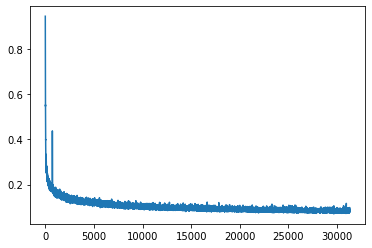

In [10]:
plt.plot(train_losses)
plt.show()

In [11]:
#model